In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+423.g8edac8237.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.08 GB available memory.


# QH Results

In [4]:
eqfam = desc.io.load("eqfam_rotated_poincare_optimize_QH_wqs1.0_war50.0_wvol10.0.h5")

In [5]:
eq = eqfam[-1]
eq0 = eqfam[0]
eqh = get("precise_QH")
eq_rotated = eq.copy()
eq0_rotated = eq0.copy()
eq_rotated = rotate_zeta(eq_rotated, angle=np.pi / eq.NFP)
eq0_rotated = rotate_zeta(eq0_rotated, angle=np.pi / eq.NFP)

In [6]:
V = eqh.compute("V")["V"]
print(f"Volume: {V:.6f}")

Volume: 0.303523


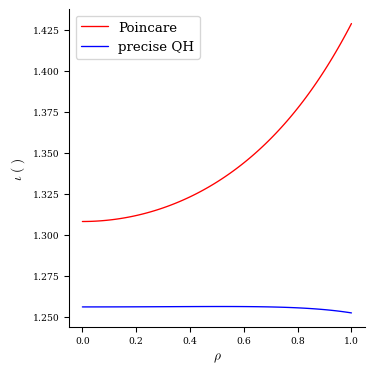

In [7]:
fig, ax = plot_1d(eq, "iota", label="Poincare", color="red")
plot_1d(eqh, "iota", ax=ax, label="precise QH", color="blue")
plt.savefig("iota_poincare_optimize_QH_wqs1.0_war50.0_wvol10.0.png", dpi=300)

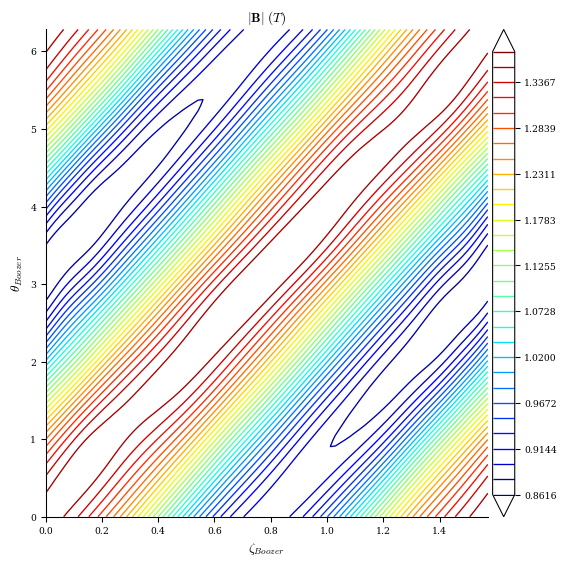

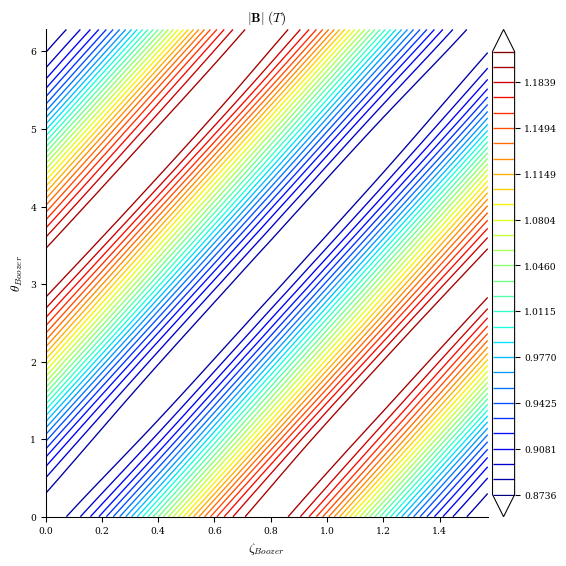

In [8]:
rho = 1
plot_boozer_surface(eq, rho=rho)
plt.savefig(
    f"boozer_rho{rho}_poincare_optimize_QH_wqs1.0_war50.0_wvol10.0.png",
    dpi=300,
)
plot_boozer_surface(eqh, rho=rho);

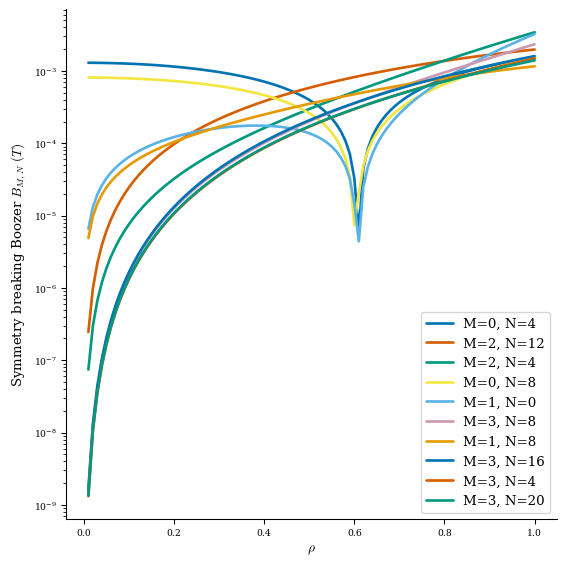

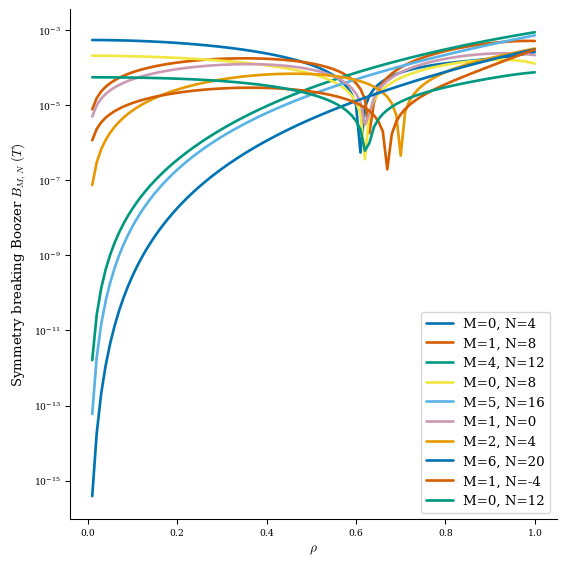

In [9]:
rho = 100
plot_boozer_modes(eq, helicity=(1, eq.NFP), rho=rho)
plot_boozer_modes(eqh, helicity=(1, eq.NFP), rho=rho);

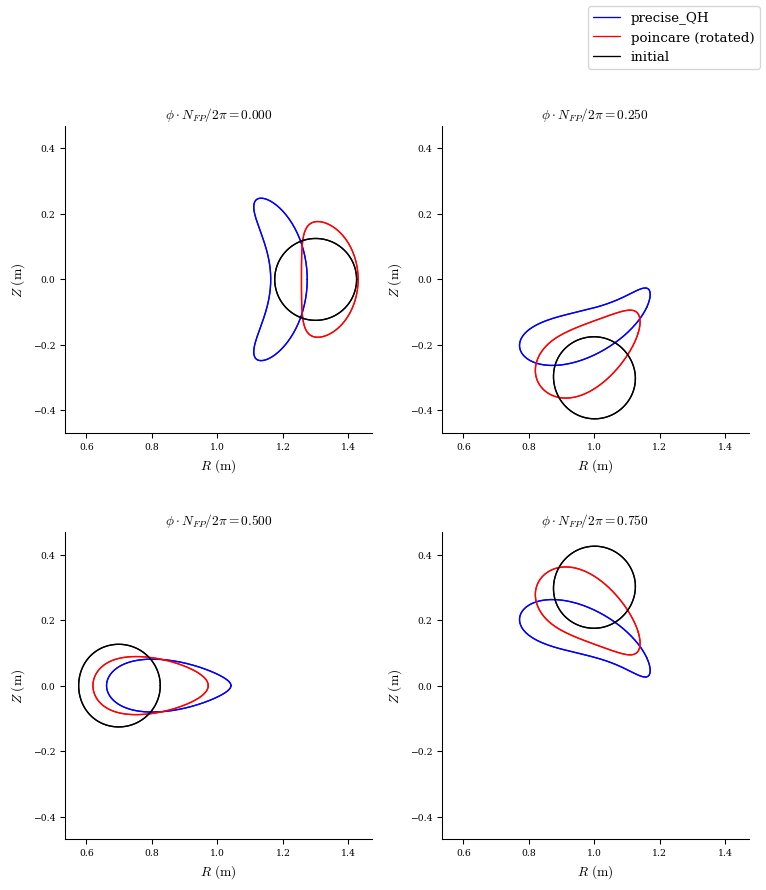

In [10]:
plot_comparison(
    [eqh, eq_rotated, eq0_rotated],
    labels=["precise_QH", "poincare (rotated)", "initial"],
    color=["blue", "red", "black"],
    theta=0,
    rho=1,
    phi=4,
)
plt.savefig(
    "surface_poincare_optimize_QH_wqs1.0_war50.0_wvol10.0.pdf", dpi=400
)

# QA Results

In [50]:
eqfam = desc.io.load("eqfam_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.h5")
eq = eqfam[-1]
eq0 = eqfam[0]
eqh = get("precise_QA")
eq_rotated = eq.copy()
eq_rotated = rotate_zeta(eq_rotated, angle=np.pi / eq.NFP)

In [29]:
V = eqh.compute("V")["V"]
print(f"Volume: {V:.6f}")

Volume: 0.600325


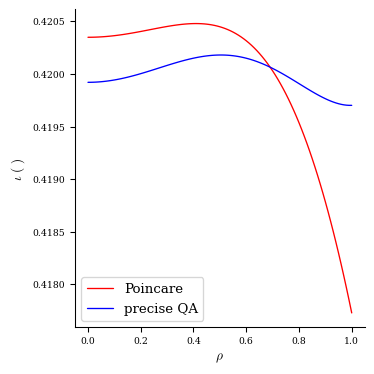

In [13]:
fig, ax = plot_1d(eq, "iota", label="Poincare", color="red")
plot_1d(eqh, "iota", ax=ax, label="precise QA", color="blue");
plt.savefig(
    "iota_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.png", dpi=300
)

(<Figure size 576.162x576.162 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

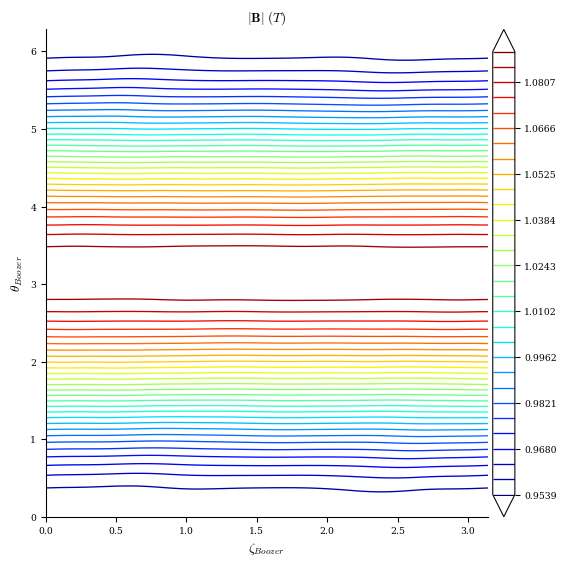

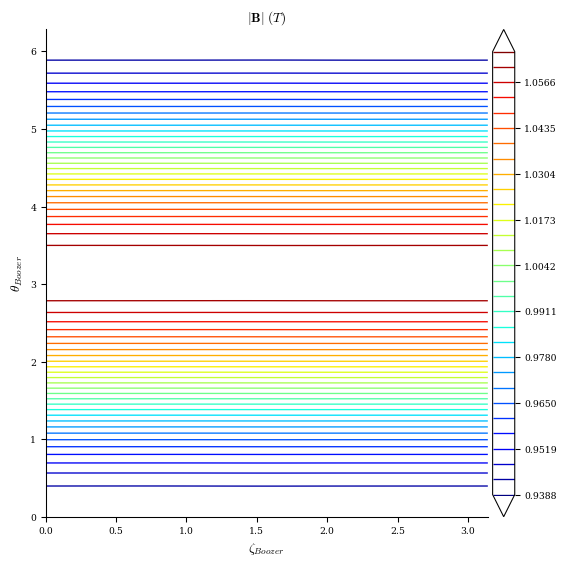

In [14]:
rho = 0.6
plot_boozer_surface(eq, rho=rho)
plt.savefig(f"boozer_rho{rho}_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.png", dpi=300)
plot_boozer_surface(eqh, rho=rho)

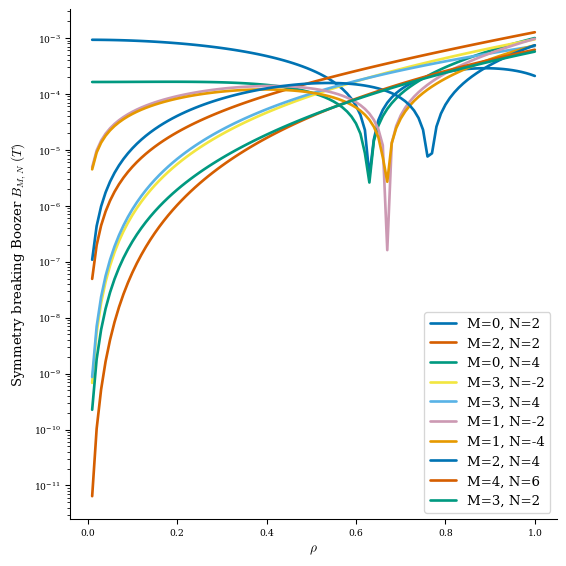

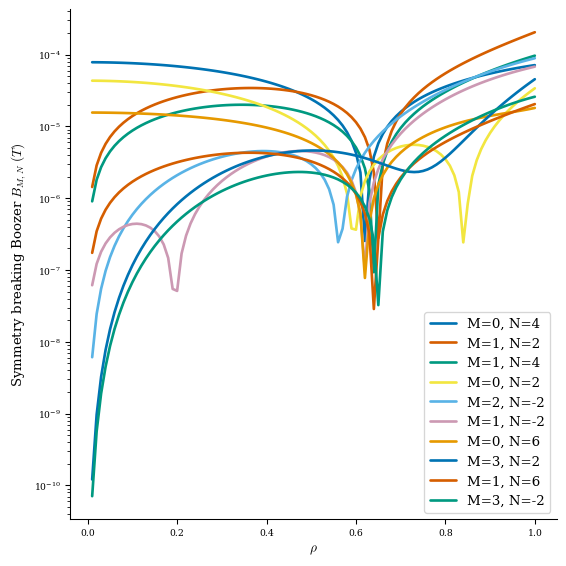

In [17]:
rho = 100
plot_boozer_modes(eq, helicity=(1, 0), rho=rho)
plot_boozer_modes(eqh, helicity=(1, 0), rho=rho);

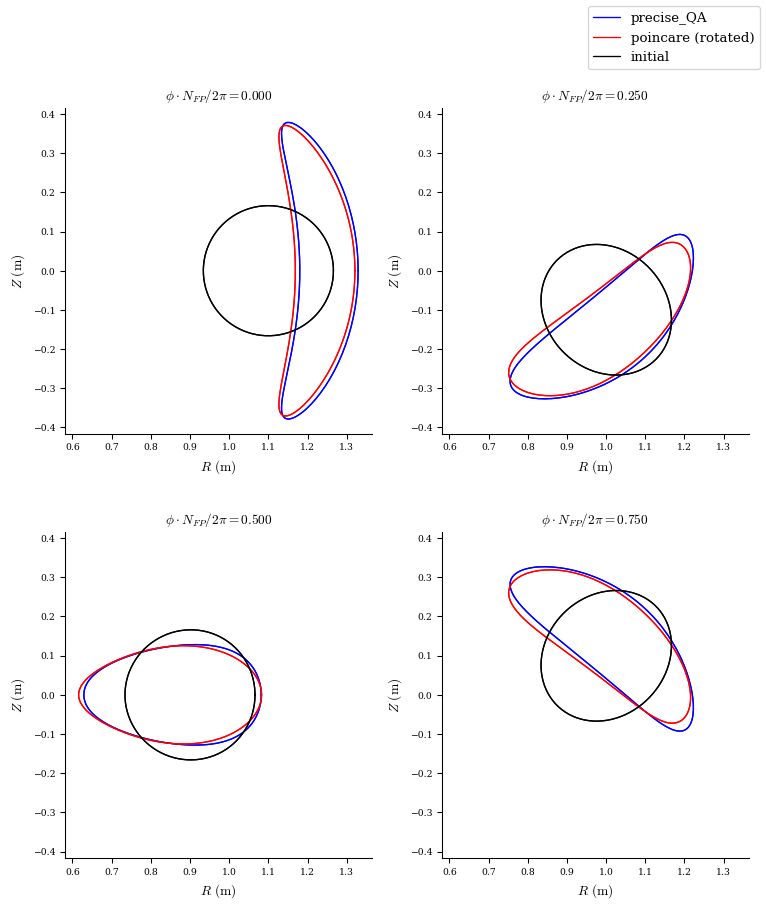

In [18]:
plot_comparison(
    [eqh, eq_rotated, eq0],
    labels=["precise_QA", "poincare (rotated)", "initial"],
    color=["blue", "red", "black"],
    theta=0,
    rho=1,
    phi=4,
);
plt.savefig("surface_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.png", dpi=400)

In [51]:
def set_poincare_equilibrium(eq, ensure_nested=True):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
        ensure_nested=ensure_nested,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

(<Figure size 384.108x480.135 with 1 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>], dtype=object))

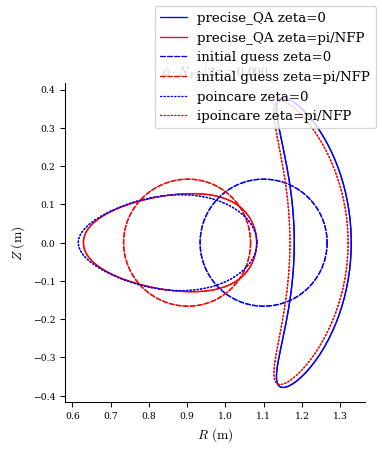

In [69]:
from desc.compat import rotate_zeta
eqh_0_section = set_poincare_equilibrium(eqh)
eqh_pi_section = set_poincare_equilibrium(rotate_zeta(eqh, angle=np.pi/eq.NFP, copy=True))
eq0_0_section = set_poincare_equilibrium(eq0)
eq0_pi_section = set_poincare_equilibrium(
    rotate_zeta(eq0, angle=np.pi / eq.NFP, copy=True)
)
eq_0_section = set_poincare_equilibrium(eq)
eq_pi_section = set_poincare_equilibrium(
    rotate_zeta(eq, angle=np.pi / eq.NFP, copy=True)
)

eqh_0_section.change_resolution(N=0)
eqh_pi_section.change_resolution(N=0)
eq0_0_section.change_resolution(N=0)
eq0_pi_section.change_resolution(N=0)
eq_0_section.change_resolution(N=0)
eq_pi_section.change_resolution(N=0)

plot_comparison(
    [
        eqh_0_section,
        eqh_pi_section,
        eq0_0_section,
        eq0_pi_section,
        eq_0_section,
        eq_pi_section,
    ],
    labels=[
        "precise_QA zeta=0",
        "precise_QA zeta=pi/NFP",
        "initial guess zeta=0",
        "initial guess zeta=pi/NFP",
        "poincare zeta=0",
        "ipoincare zeta=pi/NFP",
    ],
    color=["blue", "red", "blue", "red", "blue", "red"],
    ls=["-", "-", "--", "--", ":", ":"],
    theta=0,
    rho=1,
    phi=1,
)

0.9951211653206922
0.9989855689760838
0.993192574871173
0.9964202631041098


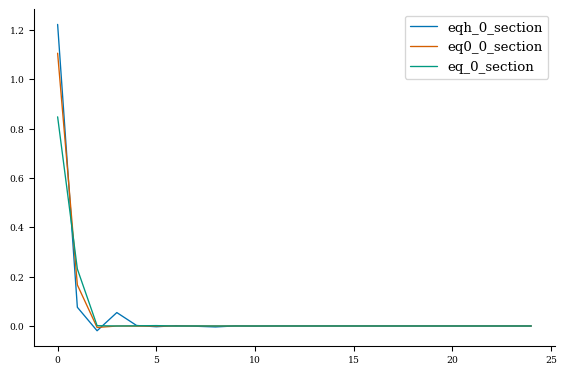

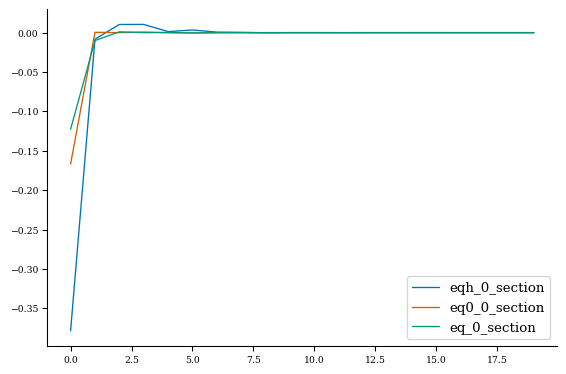

In [70]:
plt.plot(eqh_0_section.R_lmn, label="eqh_0_section")
plt.plot(eq0_0_section.R_lmn, label="eq0_0_section")
plt.plot(eq_0_section.R_lmn, label="eq_0_section")
plt.legend();
plt.figure()
plt.plot(eqh_0_section.Z_lmn, label="eqh_0_section")
plt.plot(eq0_0_section.Z_lmn, label="eq0_0_section")
plt.plot(eq_0_section.Z_lmn, label="eq_0_section")
plt.legend()
print(
    np.dot(eqh_0_section.R_lmn, eq0_0_section.R_lmn)
    / np.linalg.norm(eq0_0_section.R_lmn)
    / np.linalg.norm(eqh_0_section.R_lmn)
)
print(
    np.dot(eqh_0_section.Z_lmn, eq0_0_section.Z_lmn)
    / np.linalg.norm(eq0_0_section.Z_lmn)
    / np.linalg.norm(eqh_0_section.Z_lmn)
)
print(
    np.dot(eq_0_section.R_lmn, eq0_0_section.R_lmn)
    / np.linalg.norm(eq0_0_section.R_lmn)
    / np.linalg.norm(eq_0_section.R_lmn)
)
print(
    np.dot(eq_0_section.Z_lmn, eq0_0_section.Z_lmn)
    / np.linalg.norm(eq0_0_section.Z_lmn)
    / np.linalg.norm(eq_0_section.Z_lmn)
)

0.9914641907298913
0.9495014563789028
0.9948351557234695
0.9977602506562799


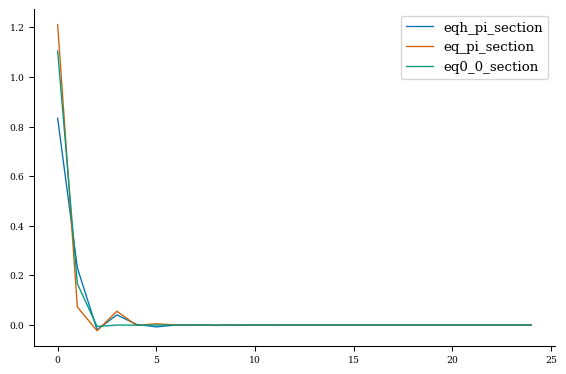

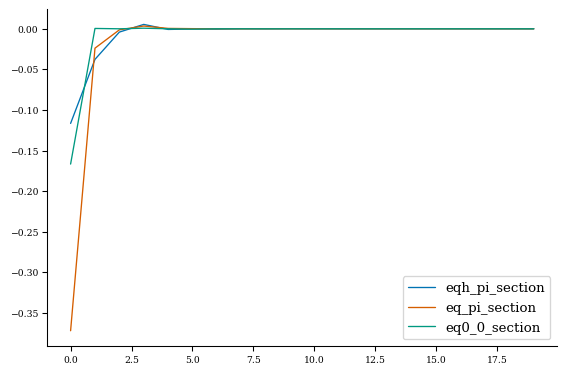

In [71]:
plt.plot(eqh_pi_section.R_lmn, label="eqh_pi_section")
plt.plot(eq_pi_section.R_lmn, label="eq_pi_section")
plt.plot(eq0_0_section.R_lmn, label="eq0_0_section")
plt.legend()
plt.figure()
plt.plot(eqh_pi_section.Z_lmn, label="eqh_pi_section")
plt.plot(eq_pi_section.Z_lmn, label="eq_pi_section")
plt.plot(eq0_0_section.Z_lmn, label="eq0_0_section")
plt.legend()
print(
    np.dot(eqh_pi_section.R_lmn, eq0_0_section.R_lmn)
    / np.linalg.norm(eq0_0_section.R_lmn)
    / np.linalg.norm(eqh_pi_section.R_lmn)
)
print(
    np.dot(eqh_pi_section.Z_lmn, eq0_0_section.Z_lmn)
    / np.linalg.norm(eq0_0_section.Z_lmn)
    / np.linalg.norm(eqh_pi_section.Z_lmn)
)
print(
    np.dot(eq_pi_section.R_lmn, eq0_0_section.R_lmn)
    / np.linalg.norm(eq0_0_section.R_lmn)
    / np.linalg.norm(eq_pi_section.R_lmn)
)
print(
    np.dot(eq_pi_section.Z_lmn, eq0_0_section.Z_lmn)
    / np.linalg.norm(eq0_0_section.Z_lmn)
    / np.linalg.norm(eq_pi_section.Z_lmn)
)

0.9807417331060048
0.8568503245564555


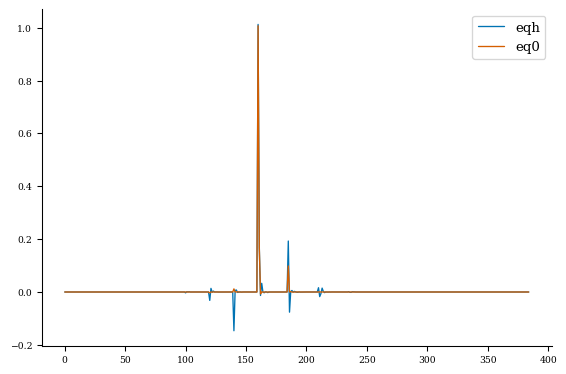

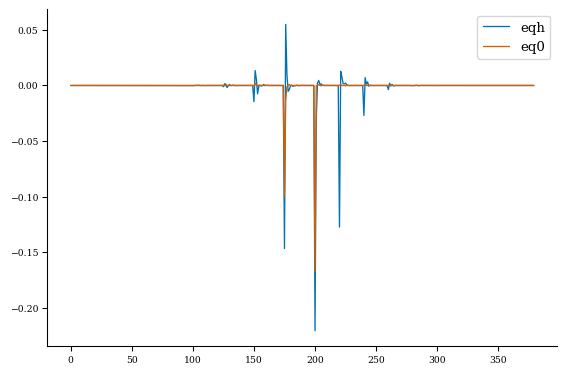

In [62]:
plt.plot(eqh.R_lmn, label="eqh")
plt.plot(eq0.R_lmn, label="eq0")
plt.legend()
plt.figure()
plt.plot(eqh.Z_lmn, label="eqh")
plt.plot(eq0.Z_lmn, label="eq0")
plt.legend()
print(
    np.dot(eqh.R_lmn, eq0.R_lmn) / np.linalg.norm(eq0.R_lmn) / np.linalg.norm(eqh.R_lmn)
)
print(
    np.dot(eqh.Z_lmn, eq0.Z_lmn) / np.linalg.norm(eq0.Z_lmn) / np.linalg.norm(eqh.Z_lmn)
)

0.9489659090676275
0.3914008430264838


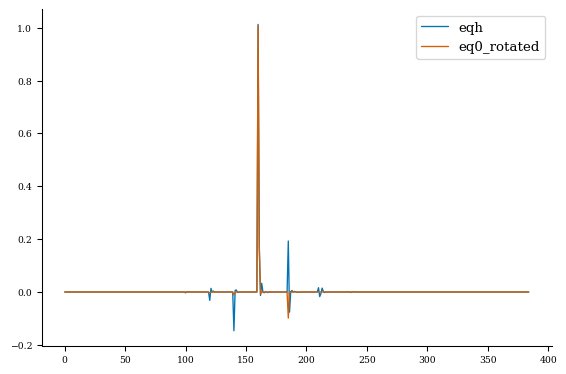

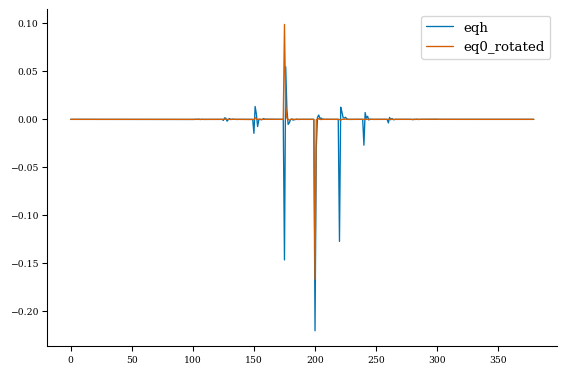

In [63]:
eq0_rotated = rotate_zeta(eq0, angle=np.pi / eq.NFP, copy=True)
plt.plot(eqh.R_lmn, label="eqh")
plt.plot(eq0_rotated.R_lmn, label="eq0_rotated")
plt.legend()
plt.figure()
plt.plot(eqh.Z_lmn, label="eqh")
plt.plot(eq0_rotated.Z_lmn, label="eq0_rotated")
plt.legend()
print(
    np.dot(eqh.R_lmn, eq0_rotated.R_lmn)
    / np.linalg.norm(eq0_rotated.R_lmn)
    / np.linalg.norm(eqh.R_lmn)
)
print(
    np.dot(eqh.Z_lmn, eq0_rotated.Z_lmn)
    / np.linalg.norm(eq0_rotated.Z_lmn)
    / np.linalg.norm(eqh.Z_lmn)
)

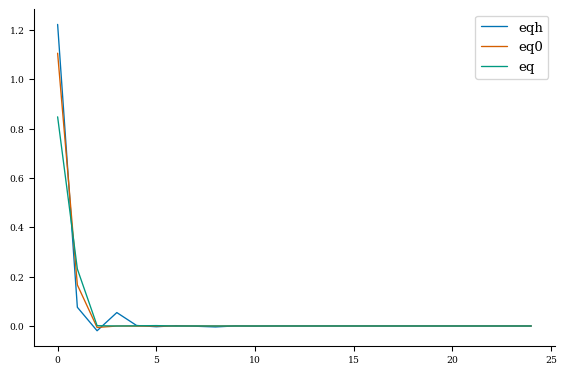

In [67]:
plt.plot(eqh.xsection.R_lmn, label="eqh")
plt.plot(eq0.xsection.R_lmn, label="eq0")
plt.plot(eq.xsection.R_lmn, label="eq")
plt.legend();

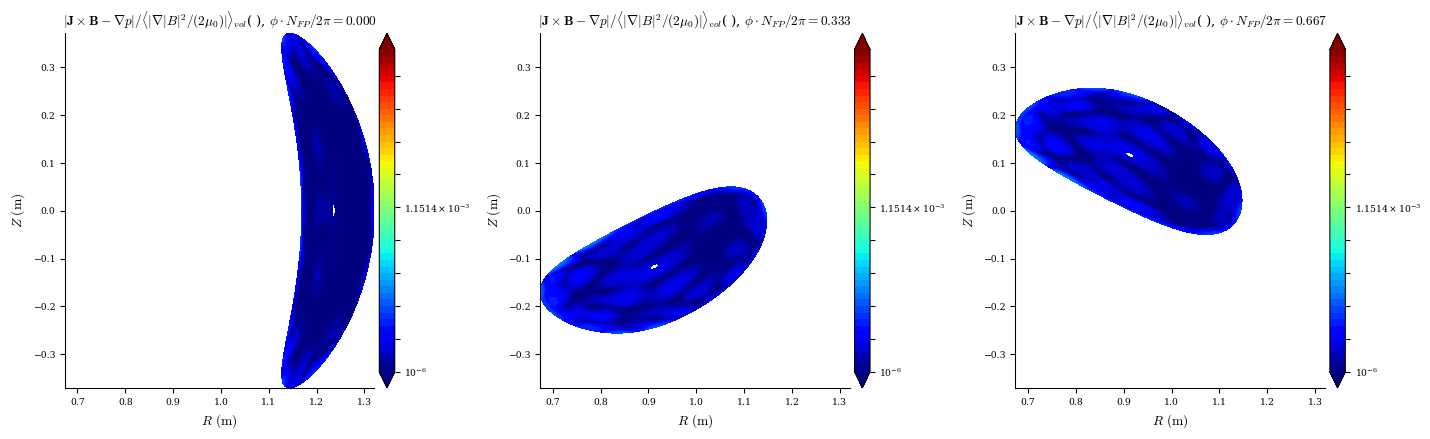

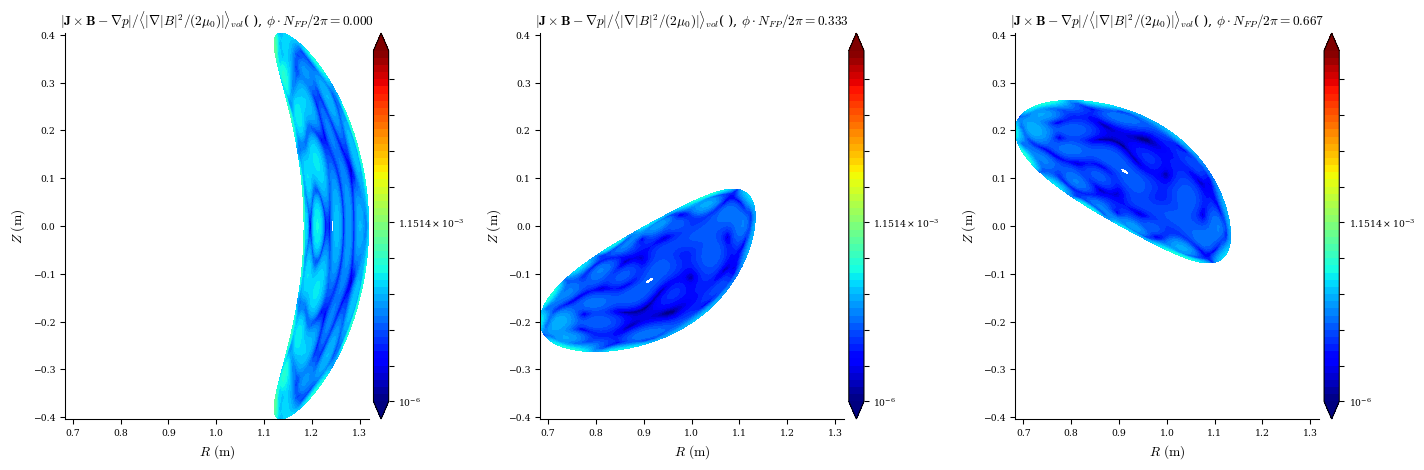

In [26]:
levels = np.logspace(-6, 0, 50)
plot_section(eq_rotated, "|F|_normalized", log=True, levels=levels, phi=3)
plt.savefig(
    "force_poincare_optimize_QA_wqs1.0_war10.0_wvol10.0_wiota20.0.png", dpi=500
)
plot_section(eqh, "|F|_normalized", log=True, levels=levels, phi=3)
plt.savefig("force_precise_QA.png", dpi=500)

(<Figure size 576.113x576.113 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

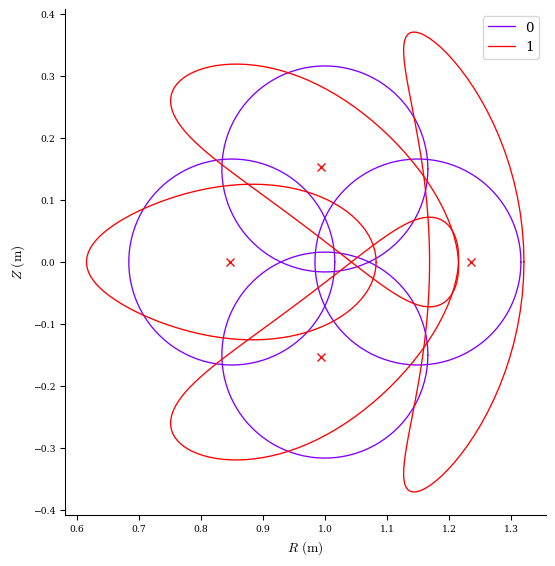

In [43]:
rmin = 0.166
rmaj = 1
dz = 0.15
surf = FourierRZToroidalSurface(
    R_lmn=[1, rmin, dz],
    Z_lmn=[-rmin, -dz],
    modes_R=[[0, 0], [1, 0], [0, 1]],
    modes_Z=[[-1, 0], [0, -1]],
    NFP=2,
)
plot_boundaries([surf, eq])